In [2]:
import pandas as pd
import os
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split,  GroupShuffleSplit
from sklearn.metrics import average_precision_score, auc, roc_curve, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt 
%matplotlib inline

import pandas as pd
import numpy as np
import re


### Read trainig data of 3 months data of leakag removal trx date > src sizes data 

In [3]:
merge_size_label=pd.read_pickle('/data/ebay/data/olivyatan/size_data/merged_label_srcs_time_features_030723.pkl')

In [4]:
merge_size_label.shape

(1035021, 42)

In [5]:
merge_size_label.head(5)

,user_id,leaf_id,merged_sizes_all_srcs,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,transactions_std,...,transactions_mostRecentCommonSize_DaysDiff,queries_mostRecentCommonSize,filters_mostRecentCommonSize,transactions_mostRecentCommonSize,queries_mostRecentCommonSize_CountOfEvidence,filters_mostRecentCommonSize_CountOfEvidence,transactions_mostRecentCommonSize_CountOfEvidence,label_trx_dt,label_user_size,label_trx_size
0,60,15709,"{12.0: 1, 12.5: 1, 7.0: 1, 13.0: 1, 5.0: 1}",3.261901,9.900000,12.0,5.0,8.0,5,3.261901,...,46.0,NaN,NaN,5.0,NaN,NaN,1.0,2023-04-05,{13.0: 1},13.0
1,60,95672,"{6.5: 28, 8.0: 1, 8.5: 1}",0.441273,6.616667,6.5,6.5,2.0,30,0.801784,...,8.0,6.5,6.5,6.5,5.0,5.0,1.0,2023-03-23,{6.5: 1},6.5
2,77,95672,{8.5: 2},0.000000,8.500000,8.5,8.5,0.0,2,0.000000,...,7.0,NaN,NaN,8.5,NaN,NaN,1.0,2022-10-23,{8.5: 1},8.5
3,192,95672,{8.5: 1},0.000000,8.500000,8.5,8.5,0.0,1,0.000000,...,34.0,NaN,NaN,8.5,NaN,NaN,1.0,2022-06-24,{8.5: 1},8.5
4,2520,15709,{12.0: 1},0.000000,12.000000,12.0,12.0,0.0,1,0.000000,...,99.0,NaN,NaN,12.0,NaN,NaN,1.0,2023-01-07,{13.0: 1},13.0


In [8]:
merge_size_label.columns

Index(['user_id', 'leaf_id', 'merged_sizes_all_srcs', 'merged_std',
       'merged_mean', 'merged_median', 'merged_mode', 'merged_maxMinDiff',
       'merged_countOfEvidence', 'transactions_std', 'transactions_mean',
       'transactions_median', 'transactions_mode', 'transactions_maxMinDiff',
       'transactions_countOfEvidence', 'queries_std', 'queries_mean',
       'queries_median', 'queries_mode', 'queries_maxMinDiff',
       'queries_countOfEvidence', 'filters_std', 'filters_mean',
       'filters_median', 'filters_mode', 'filters_maxMinDiff',
       'filters_countOfEvidence', 'mostRecentCommonSize_DaysDiff',
       'mostRecentCommonSize', 'mostRecentCommonSize_CountOfEvidence',
       'queries_mostRecentCommonSize_DaysDiff',
       'filters_mostRecentCommonSize_DaysDiff',
       'transactions_mostRecentCommonSize_DaysDiff',
       'queries_mostRecentCommonSize', 'filters_mostRecentCommonSize',
       'transactions_mostRecentCommonSize',
       'queries_mostRecentCommonSize_Count

In [6]:
merge_size_label = merge_size_label.fillna(np.nan)

In [7]:
model_list = ['user_id', 'leaf_id', 'merged_sizes_all_srcs', 'merged_std',
       'merged_mean', 'merged_median', 'merged_mode', 'merged_maxMinDiff',
       'merged_countOfEvidence', 'transactions_std', 'transactions_mean',
       'transactions_median', 'transactions_mode', 'transactions_maxMinDiff',
       'transactions_countOfEvidence', 'queries_std', 'queries_mean',
       'queries_median', 'queries_mode', 'queries_maxMinDiff',
       'queries_countOfEvidence', 'filters_std', 'filters_mean',
       'filters_median', 'filters_mode', 'filters_maxMinDiff',
       'filters_countOfEvidence', 'mostRecentCommonSize_DaysDiff',
       'mostRecentCommonSize', 'mostRecentCommonSize_CountOfEvidence',
       'queries_mostRecentCommonSize_DaysDiff',
       'filters_mostRecentCommonSize_DaysDiff',
       'transactions_mostRecentCommonSize_DaysDiff',
       'queries_mostRecentCommonSize', 'filters_mostRecentCommonSize',
       'transactions_mostRecentCommonSize',
       'queries_mostRecentCommonSize_CountOfEvidence',
       'filters_mostRecentCommonSize_CountOfEvidence',
       'transactions_mostRecentCommonSize_CountOfEvidence', 'label_trx_dt',
       'label_user_size', 'label_trx_size']

In [8]:
df_model = merge_size_label[model_list]

In [9]:
only_features = [ 'merged_std',
       'merged_mean', 'merged_median', 'merged_mode', 'merged_maxMinDiff',
       'merged_countOfEvidence', 'transactions_std', 'transactions_mean',
       'transactions_median', 'transactions_mode', 'transactions_maxMinDiff',
       'transactions_countOfEvidence', 'queries_std', 'queries_mean',
       'queries_median', 'queries_mode', 'queries_maxMinDiff',
       'queries_countOfEvidence', 'filters_std', 'filters_mean',
       'filters_median', 'filters_mode', 'filters_maxMinDiff',
       'filters_countOfEvidence', 'mostRecentCommonSize_DaysDiff',
       'mostRecentCommonSize', 'mostRecentCommonSize_CountOfEvidence',
       'queries_mostRecentCommonSize_DaysDiff',
       'filters_mostRecentCommonSize_DaysDiff',
       'transactions_mostRecentCommonSize_DaysDiff',
       'queries_mostRecentCommonSize', 'filters_mostRecentCommonSize',
       'transactions_mostRecentCommonSize',
       'queries_mostRecentCommonSize_CountOfEvidence',
       'filters_mostRecentCommonSize_CountOfEvidence',
       'transactions_mostRecentCommonSize_CountOfEvidence']

In [10]:
len(only_features)

36

In [11]:
df_model_na = df_model.dropna(how='all', subset = only_features)

In [12]:
df_features = merge_size_label[only_features]
df_feat_na = df_features.dropna(how='all')

In [13]:
df_features.shape, df_feat_na.shape

((1035021, 36), (1035021, 36))

In [14]:
len(merge_size_label.user_id.unique())

988566

In [15]:
len(merge_size_label.user_id.unique())

988566

In [16]:
merge_size_label.label_trx_size.value_counts()

10.0    118807
11.0    108445
9.0     106146
10.5     89330
12.0     86611
9.5      85797
8.0      79306
8.5      69333
13.0     59610
11.5     50819
7.0      47512
7.5      37494
6.0      21242
14.0     19716
6.5      18778
12.5      9764
5.0       7784
15.0      7446
5.5       6286
16.0      2019
4.5       1569
13.5       928
14.5       232
15.5        47
Name: label_trx_size, dtype: int64

In [17]:
df_model_na[df_model_na['label_trx_size'].isin([10.25,9.75,10.75])]

,user_id,leaf_id,merged_sizes_all_srcs,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,transactions_std,...,transactions_mostRecentCommonSize_DaysDiff,queries_mostRecentCommonSize,filters_mostRecentCommonSize,transactions_mostRecentCommonSize,queries_mostRecentCommonSize_CountOfEvidence,filters_mostRecentCommonSize_CountOfEvidence,transactions_mostRecentCommonSize_CountOfEvidence,label_trx_dt,label_user_size,label_trx_size


In [18]:
df_model_na=df_model_na[~df_model_na['label_trx_size'].isin([10.25,9.75,10.75])]

In [19]:
df_model_na.label_trx_size.nunique()

24

In [20]:
df_model_na.head(2)

,user_id,leaf_id,merged_sizes_all_srcs,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,transactions_std,...,transactions_mostRecentCommonSize_DaysDiff,queries_mostRecentCommonSize,filters_mostRecentCommonSize,transactions_mostRecentCommonSize,queries_mostRecentCommonSize_CountOfEvidence,filters_mostRecentCommonSize_CountOfEvidence,transactions_mostRecentCommonSize_CountOfEvidence,label_trx_dt,label_user_size,label_trx_size
0,60,15709,"{12.0: 1, 12.5: 1, 7.0: 1, 13.0: 1, 5.0: 1}",3.261901,9.900000,12.0,5.0,8.0,5,3.261901,...,46.0,NaN,NaN,5.0,NaN,NaN,1.0,2023-04-05,{13.0: 1},13.0
1,60,95672,"{6.5: 28, 8.0: 1, 8.5: 1}",0.441273,6.616667,6.5,6.5,2.0,30,0.801784,...,8.0,6.5,6.5,6.5,5.0,5.0,1.0,2023-03-23,{6.5: 1},6.5


In [21]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2,
                                               random_state = 7).split(df_model_na,
                                                                       groups=df_model_na['user_id']))

train = df_model_na.iloc[train_inds]
test = df_model_na.iloc[test_inds]

In [22]:
val_inds, test_inds = next(GroupShuffleSplit(test_size=.5, n_splits=2,
                                               random_state = 7).split(test,
                                                                       groups=test['user_id']))

val = test.iloc[val_inds]
test = test.iloc[test_inds]

In [23]:
train_inds

array([      0,       1,       2, ..., 1035018, 1035019, 1035020])

In [24]:
test.head(3)

,user_id,leaf_id,merged_sizes_all_srcs,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,transactions_std,...,transactions_mostRecentCommonSize_DaysDiff,queries_mostRecentCommonSize,filters_mostRecentCommonSize,transactions_mostRecentCommonSize,queries_mostRecentCommonSize_CountOfEvidence,filters_mostRecentCommonSize_CountOfEvidence,transactions_mostRecentCommonSize_CountOfEvidence,label_trx_dt,label_user_size,label_trx_size
30,10555,95672,{10.0: 1},0.000000,10.0,10.0,10.0,0.0,1,0.000000,...,4.0,NaN,NaN,10.0,NaN,NaN,1.0,2022-05-07,{9.5: 1},9.5
31,10681,95672,"{7.5: 1, 6.5: 1, 7.0: 1}",0.408248,7.0,7.0,6.5,1.0,3,0.408248,...,20.0,NaN,NaN,7.0,NaN,NaN,1.0,2022-11-12,{8.0: 1},8.0
49,14654,15709,{10.5: 1},0.000000,10.5,10.5,10.5,0.0,1,0.000000,...,135.0,NaN,NaN,10.5,NaN,NaN,1.0,2023-03-30,{10.5: 1},10.5


In [25]:
val.head(3)

,user_id,leaf_id,merged_sizes_all_srcs,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,transactions_std,...,transactions_mostRecentCommonSize_DaysDiff,queries_mostRecentCommonSize,filters_mostRecentCommonSize,transactions_mostRecentCommonSize,queries_mostRecentCommonSize_CountOfEvidence,filters_mostRecentCommonSize_CountOfEvidence,transactions_mostRecentCommonSize_CountOfEvidence,label_trx_dt,label_user_size,label_trx_size
7,3285,95672,{8.0: 1},0.000000,8.00,8.0,8.0,0.0,1,0.0,...,108.0,NaN,NaN,8.0,NaN,NaN,1.0,2023-02-19,{8.0: 1},8.0
12,4767,95672,{9.5: 10},0.000000,9.50,9.5,9.5,0.0,10,NaN,...,NaN,NaN,9.5,NaN,NaN,1.0,NaN,2023-03-24,{9.5: 1},9.5
33,11067,15709,"{10.5: 3, 7.5: 1}",1.299038,9.75,10.5,10.5,3.0,4,NaN,...,NaN,NaN,7.5,NaN,NaN,1.0,NaN,2023-03-12,{7.0: 1},7.0


In [26]:
len(train), len(val), len(test)

(828136, 103522, 103363)

In [27]:
df_model_na.label_trx_size.unique()

array([13. ,  6.5,  8.5, 10.5,  8. , 10. ,  9.5, 12. , 11. ,  6. , 12.5,
        9. ,  7.5, 11.5, 14. ,  7. , 16. , 15. ,  5.5,  5. , 13.5,  4.5,
       14.5, 15.5])

In [28]:
df_model_na.label_trx_size.nunique()

24

In [29]:
TRAIN_COLS =only_features

In [30]:
type(train.loc[0,'label_trx_size'])

numpy.float64

In [72]:
type(train.loc[0,'merged_median'])

numpy.float64

In [31]:
df_model_na.dtypes

user_id                                                int64
leaf_id                                                int64
merged_sizes_all_srcs                                 object
merged_std                                           float64
merged_mean                                          float64
merged_median                                        float64
merged_mode                                          float64
merged_maxMinDiff                                    float64
merged_countOfEvidence                                 int64
transactions_std                                     float64
transactions_mean                                    float64
transactions_median                                  float64
transactions_mode                                    float64
transactions_maxMinDiff                              float64
transactions_countOfEvidence                         float64
queries_std                                          float64
queries_mean            

In [30]:
df_model_na.label_trx_size.nunique()

24

In [31]:
train_cols =only_features

## 1. xgboost:

In [32]:
param = {'max_depth': 4, 'min_child_weight': 4, 'eta': 0.3,'subsample':1,  'objective': 'multi:softmax','num_class': df_model_na.label_trx_size.nunique()}
param['nthread'] = 2
param['eval_metric'] = [  'mlogloss', 'merror']
#'auc',
evallist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 20
early_stopping_rounds=5

In [33]:
param

{'max_depth': 4,
 'min_child_weight': 4,
 'eta': 0.3,
 'subsample': 1,
 'objective': 'multi:softmax',
 'num_class': 24,
 'nthread': 2,
 'eval_metric': ['mlogloss', 'merror']}

In [34]:
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-mlogloss:2.11908	eval-merror:0.44135	train-mlogloss:2.11438	train-merror:0.44106
[1]	eval-mlogloss:1.93944	eval-merror:0.42542	train-mlogloss:1.93469	train-merror:0.42601
[2]	eval-mlogloss:1.81227	eval-merror:0.43039	train-mlogloss:1.80833	train-merror:0.43046
[3]	eval-mlogloss:1.71788	eval-merror:0.43297	train-mlogloss:1.71262	train-merror:0.43278
[4]	eval-mlogloss:1.64406	eval-merror:0.43200	train-mlogloss:1.63964	train-merror:0.43180
[5]	eval-mlogloss:1.58529	eval-merror:0.43315	train-mlogloss:1.58040	train-merror:0.43283
[6]	eval-mlogloss:1.53721	eval-merror:0.43300	train-mlogloss:1.53221	train-merror:0.43267
[7]	eval-mlogloss:1.49712	eval-merror:0.42917	train-mlogloss:1.49213	train-merror:0.42930
[8]	eval-mlogloss:1.46376	eval-merror:0.42865	train-mlogloss:1.45789	train-merror:0.42877
[9]	eval-mlogloss:1.43554	eval-merror:0.42856	train-mlogloss:1.43056	train-merror:0.42874
[10]	eval-mlogloss:1.40974	eval-merror:0.42819	train-mlogloss:1.40446	train-merror:0.42850
[11]	eval

In [35]:
bst.best_ntree_limit

20

In [36]:
ntree_limit=bst.best_ntree_limit

In [37]:
ntree_limit

20

In [38]:
a = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


In [39]:
a

array([10.,  7., 11., ..., 10., 10., 13.], dtype=float32)

In [40]:
ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
test['pred'] = ypred

### micro precison:

In [52]:
gain_importance_df =pd.DataFrame.from_dict(gain_importance, orient = 'index')
gain_importance_df.columns = ['gain']
gain_importance_df.sort_values('gain', ascending=False)

,gain
merged_median,3553.679402
merged_mode,2293.392339
merged_std,104.117464
merged_mean,97.073387
merged_countOfEvidence,88.237058
merged_maxMinDiff,18.452472


In [32]:
from sklearn.metrics import precision_score

In [29]:
y_true=test['label_trx_size'].astype(str).tolist()
y_pred_stat=test['merged_mode'].astype(str).tolist()

In [33]:
precision_score(y_true, y_pred_stat, average='micro')

0.6166877541362025

In [ ]:
#Precision of median as predictor: #Precision of median as predictor: 

In [64]:
y_true=test['label_trx_size'].astype(str).tolist()
y_pred_stat=test['merged_median'].astype(str).tolist()
precision_score(y_true, y_pred_stat, average='micro')

0.591566299970059

In [65]:
#Precision of mean as predictor: 

In [34]:
y_true=test['label_trx_size'].astype(str).tolist()
y_pred_stat=test['merged_mean'].astype(str).tolist()
precision_score(y_true, y_pred_stat, average='micro')

0.4435129470624028

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

y_train=train['label_trx_size'].astype(str)
train_f=train[only_features] 
test_f=test[only_features] 
val_f=val[only_features] 

In [69]:
clf = RandomForestClassifier(max_depth=12 , n_estimators=100, random_state=0 )
clf.fit(train_f, y_train)

RandomForestClassifier(max_depth=12, random_state=0)

In [70]:
rf_predict= clf.predict(test_f)

In [71]:
test['pred_rf'] = rf_predict

In [72]:
from sklearn.metrics import precision_score
#Calculate metrics globally by counting the total true positives, false negatives and false positives.

precision_score(y_true=test['label_trx_size'].astype(str).tolist(), y_pred=test['pred_rf'].astype(str).tolist(), average='micro')

0.6216231878458909

In [353]:
test.head(3)

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,pred,pred_mode,pred_rf
8,2741,95672,0.000000,8.500000,8.5,8.5,0.0,2,8.5,9.0,9.0,8.5
40,11010,15709,0.000000,14.000000,14.0,14.0,0.0,4,14.0,14.0,14.0,14.0
55,14355,15709,0.000000,10.500000,10.5,10.5,0.0,3,10.5,11.0,11.0,10.5
56,14468,95672,0.276385,7.583333,7.5,7.5,1.0,12,7.5,8.0,8.0,7.5
65,19016,15709,0.000000,10.000000,10.0,10.0,0.0,16,10.0,10.0,10.0,10.0
76,22439,15709,0.000000,10.000000,10.0,10.0,0.0,6,10.0,10.0,10.0,10.0
84,23437,15709,0.000000,9.500000,9.5,9.5,0.0,2,9.5,10.0,10.0,9.5
91,24595,95672,0.000000,10.000000,10.0,10.0,0.0,1,10.0,10.0,10.0,10.0
109,29259,15709,0.000000,12.000000,12.0,12.0,0.0,1,12.0,12.0,12.0,12.0
124,34305,15709,0.000000,10.000000,10.0,10.0,0.0,1,10.0,10.0,10.0,10.0


In [73]:
rf_predict_train= clf.predict(train_f)

In [74]:
precision_score(y_true=train['label_trx_size'].astype(str).tolist(), y_pred=rf_predict_train.astype(str).tolist(), average='micro')

0.6307968795857806

In [75]:
precision_score(y_true=train['label_trx_size'].astype(str).tolist(), y_pred=train['merged_mode'].astype(str).tolist(), average='micro')

0.6184473535781015

In [76]:
val.shape

(103514, 9)

In [77]:
##xgb== label
(test.pred.astype(float)==test.label_trx_size.astype(float)).mean()

0.474004462172943

In [78]:
(test['label_trx_size'].astype(float)==test['pred_rf'].astype(float)).mean()

0.6216231878458909

In [79]:
##random forest== label
(test.pred_rf.astype(float)==test.label_trx_size.astype(float)).mean()

0.6216231878458909

In [361]:
test[test.merged_mode == 12.5]['pred_mode'].value_counts()

13.0    867
Name: pred_mode, dtype: int64

In [82]:
test.pred_rf.value_counts()

10.0    12430
11.0    11781
9.0     10794
12.0     9265
10.5     9046
9.5      8401
8.0      8015
8.5      6724
13.0     6316
7.0      4634
11.5     4485
7.5      3348
6.0      1958
14.0     1933
6.5      1516
5.0       754
15.0      751
12.5      715
5.5       446
16.0      200
14.5       13
13.5        5
4.5         5
15.5        2
Name: pred_rf, dtype: int64

In [362]:
#xgboost is rounding vals of 8.5 

In [80]:
test.pred.value_counts()

11.0    22167
10.0    20633
9.0     18097
8.0     12007
12.0    10744
13.0     6902
7.0      6737
6.0      2540
14.0     1931
5.0       814
15.0      759
16.0      206
Name: pred, dtype: int64

In [81]:
test.label_trx_size.value_counts()

10.0    11910
11.0    10809
9.0     10575
10.5     8870
12.0     8714
9.5      8608
8.0      7874
8.5      6986
13.0     5910
11.5     5095
7.0      4765
7.5      3801
6.0      2077
14.0     1962
6.5      1876
12.5     1005
15.0      789
5.0       761
5.5       620
16.0      226
4.5       175
13.5      100
14.5       28
15.5        1
Name: label_trx_size, dtype: int64

In [366]:
test.head(15)

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,pred,pred_mode,pred_rf
8,2741,95672,0.000000,8.500000,8.5,8.5,0.0,2,8.5,9.0,9.0,8.5
40,11010,15709,0.000000,14.000000,14.0,14.0,0.0,4,14.0,14.0,14.0,14.0
55,14355,15709,0.000000,10.500000,10.5,10.5,0.0,3,10.5,11.0,11.0,10.5
56,14468,95672,0.276385,7.583333,7.5,7.5,1.0,12,7.5,8.0,8.0,7.5
65,19016,15709,0.000000,10.000000,10.0,10.0,0.0,16,10.0,10.0,10.0,10.0
76,22439,15709,0.000000,10.000000,10.0,10.0,0.0,6,10.0,10.0,10.0,10.0
84,23437,15709,0.000000,9.500000,9.5,9.5,0.0,2,9.5,10.0,10.0,9.5
91,24595,95672,0.000000,10.000000,10.0,10.0,0.0,1,10.0,10.0,10.0,10.0
109,29259,15709,0.000000,12.000000,12.0,12.0,0.0,1,12.0,12.0,12.0,12.0
124,34305,15709,0.000000,10.000000,10.0,10.0,0.0,1,10.0,10.0,10.0,10.0


## 2. Xgboost - regression: 

In [84]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1
)

In [85]:
X_train=train[only_features] 
y_train=train.label_trx_size

In [86]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=104, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
X_test=test[only_features] 
y_pred = model.predict(X_test)

In [88]:
test['y_pred_xgb_reg']=y_pred

In [89]:
y_test=test.label_trx_size

In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print("MSE:", mse)
print("MAE:", mae)

MSE: 1.0664766144166022
MAE: 0.570737212750411


In [91]:
test.head(10)

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,pred,pred_mode,pred_rf,y_pred_xgb_reg
30,10555,95672,0.000000,10.0000,10.00,10.0,0.0,1,9.5,10.0,10.0,10.0,9.905399
31,10681,95672,0.408248,7.0000,7.00,6.5,1.0,3,8.0,7.0,7.0,7.0,7.276044
49,14654,15709,0.000000,10.5000,10.50,10.5,0.0,1,10.5,11.0,11.0,10.5,10.371842
59,19942,15709,0.000000,11.5000,11.50,11.5,0.0,1,11.5,11.0,12.0,11.5,11.241888
79,24200,15709,0.242061,11.1875,11.00,11.0,0.5,16,11.5,11.0,11.0,11.0,11.072761
82,25134,15709,0.250000,10.2500,10.25,10.0,0.5,4,10.5,10.0,10.0,10.5,10.184119
88,26812,95672,0.000000,9.5000,9.50,9.5,0.0,2,9.0,10.0,10.0,9.5,9.484109
117,37770,15709,0.000000,12.0000,12.00,12.0,0.0,5,12.0,12.0,12.0,12.0,11.861114
137,44657,15709,0.894427,8.5000,9.00,9.0,2.5,5,9.0,9.0,9.0,9.0,8.707980
149,47703,15709,0.000000,8.0000,8.00,8.0,0.0,7,12.0,8.0,8.0,8.0,8.110936


In [92]:
y_test.round()

30         10.0
31          8.0
49         10.0
59         12.0
79         12.0
           ... 
1034979    10.0
1035008     9.0
1035010    10.0
1035013    10.0
1035014    13.0
Name: label_trx_size, Length: 103537, dtype: float64

In [93]:
y_pred.round()

array([10.,  7., 10., ..., 10., 10., 13.], dtype=float32)

In [94]:
from sklearn.metrics import precision_score

# Assuming you have the true labels and predicted labels in y_true and y_pred arrays respectively

# Calculate micro-precision
micro_precision = precision_score(y_test.round().astype(str), y_pred.round().astype(str), average='micro')
micro_precision

0.5737079498150419

# 3.xgboost multi class: with class encoding to int: 

In [ ]:
## Use this 

In [36]:
only_features

['merged_std',
 'merged_mean',
 'merged_median',
 'merged_mode',
 'merged_maxMinDiff',
 'merged_countOfEvidence',
 'transactions_std',
 'transactions_mean',
 'transactions_median',
 'transactions_mode',
 'transactions_maxMinDiff',
 'transactions_countOfEvidence',
 'queries_std',
 'queries_mean',
 'queries_median',
 'queries_mode',
 'queries_maxMinDiff',
 'queries_countOfEvidence',
 'filters_std',
 'filters_mean',
 'filters_median',
 'filters_mode',
 'filters_maxMinDiff',
 'filters_countOfEvidence',
 'mostRecentCommonSize_DaysDiff',
 'mostRecentCommonSize',
 'mostRecentCommonSize_CountOfEvidence',
 'queries_mostRecentCommonSize_DaysDiff',
 'filters_mostRecentCommonSize_DaysDiff',
 'transactions_mostRecentCommonSize_DaysDiff',
 'queries_mostRecentCommonSize',
 'filters_mostRecentCommonSize',
 'transactions_mostRecentCommonSize',
 'queries_mostRecentCommonSize_CountOfEvidence',
 'filters_mostRecentCommonSize_CountOfEvidence',
 'transactions_mostRecentCommonSize_CountOfEvidence']

In [37]:
X_train=train[only_features] 
y_train=train.label_trx_size

In [38]:
y_float=train.label_trx_size.to_numpy()

In [39]:
y_float

array([13. ,  6.5,  8.5, ...,  7. ,  9.5, 10. ])

In [40]:
# Convert labels to integer classes
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y_float)

In [41]:
y

array([17,  4,  8, ...,  5, 10, 11])

In [42]:
len(y)

828136

In [43]:
y_float

array([13. ,  6.5,  8.5, ...,  7. ,  9.5, 10. ])

In [44]:
len(y_float)

828136

### xgboost api: multi class converting class to int: 

In [ ]:
#The LabelEncoder object assigns a unique integer value to each unique label
#in ascending order of their values. The mapping is learned and stored within the LabelEncoder object.

In [45]:
# Convert labels to integer classes
y_float_train=train.label_trx_size.to_numpy()
#creates an instance of the LabelEncoder class, which will be used to perform the label encoding.
le = LabelEncoder()
#encode categorical labels as numeric values.
y_train = le.fit_transform(y_float_train)
#fit_transform() method of the LabelEncoder class fits the encoder to the unique classes in y_float and then transforms the original labels into encoded numeric values.

In [46]:
y_float_train

array([13. ,  6.5,  8.5, ...,  7. ,  9.5, 10. ])

In [47]:
y_train

array([17,  4,  8, ...,  5, 10, 11])

In [48]:

unique_values = np.unique(y_train)
sorted_values = np.sort(unique_values)

print(sorted_values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [49]:

unique_values = np.unique(y_float_train)
sorted_values = np.sort(unique_values)

print(sorted_values)

[ 4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.
 11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16. ]


In [50]:
len(sorted_values)

24

In [51]:
X_train=train[only_features]

In [52]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)

In [53]:
import xgboost as xgb

params = {
    'objective': 'multi:softmax', 
    'num_class': len(np.unique(y_train)),
    'n_estimators': 100,
    'max_depth': 6, #4 
    'min_child_weight': 3,
    'learning_rate': 0.3
}

model = xgb.train(params, dtrain)

[13:02:23] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:03:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
gain_importance = model.get_score(importance_type='gain')
gain_importance_df =pd.DataFrame.from_dict(gain_importance, orient = 'index')
gain_importance_df.columns = ['gain']
gain_importance_df.sort_values('gain', ascending=False)

,gain
merged_mode,3819.030928
merged_median,3619.798951
mostRecentCommonSize,269.190120
merged_mean,114.206977
merged_std,72.682245
filters_std,67.797602
merged_countOfEvidence,63.226059
queries_mean,25.321322
queries_mode,23.984958
filters_mean,19.886462


In [169]:
y_float_test=test.label_trx_size.to_numpy()
le = LabelEncoder()
y_test = le.fit_transform(y_float_test)

In [170]:
y_test

array([10,  7, 12, ..., 19,  7,  8])

In [171]:
X_test=test[only_features]
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = model.predict(dtest)

In [172]:
y_pred # is index of class predicted 

array([11.,  5., 12., ..., 19.,  7.,  9.], dtype=float32)

In [173]:
# get the predicted class probabilities for each instance in dtest
y_prob_norm_margin = model.predict(dtest, output_margin=True)

In [174]:
y_prob_norm_margin

array([[-0.94841397, -0.8351049 , -0.8581503 , ..., -0.9661463 ,
        -1.025598  , -1.0052389 ],
       [-0.8800438 , -0.2501834 , -0.4015859 , ..., -0.9706264 ,
        -1.025598  , -1.0052389 ],
       [-0.94841397, -0.7457031 , -0.8670247 , ..., -0.9661463 ,
        -1.025598  , -1.0052389 ],
       ...,
       [-0.94841397, -0.8351049 , -0.8670247 , ...,  0.915362  ,
        -1.025598  , -0.5607145 ],
       [-0.94841397, -0.8052229 , -0.7650123 , ..., -0.9706264 ,
        -1.025598  , -1.0052389 ],
       [-0.94841397, -0.84081334, -0.84640783, ..., -0.9706264 ,
        -1.025598  , -1.0052389 ]], dtype=float32)

In [175]:
# get the predicted class probabilities for each instance in dtest
y_prob_n= model.predict(dtest, output_margin=False)

In [176]:
y_prob_n

array([11.,  5., 12., ..., 19.,  7.,  9.], dtype=float32)

In [177]:
y_prob_norm_margin[0]

array([-0.94841397, -0.8351049 , -0.8581503 , -0.518793  , -0.67110986,
       -0.2596231 , -0.43703607,  0.29277   ,  0.15136632,  0.8093497 ,
        1.3698055 ,  3.8582785 ,  1.5537193 ,  0.8390508 , -0.2809367 ,
       -0.01141855, -0.9452161 , -0.4981373 , -1.0152339 , -0.91247034,
       -1.0250471 , -0.9661463 , -1.025598  , -1.0052389 ], dtype=float32)

In [178]:
#Convert integer labels back to float labels:
y_pred_float = le.inverse_transform(y_pred.astype(int))

In [179]:
y_pred_float

array([10. ,  7. , 10.5, ..., 14. ,  8. ,  9. ])

In [180]:
test['xgb_pred']=y_pred_float

### Probabilities of class: 

In [181]:
y_prob_norm_margin[0]

array([-0.94841397, -0.8351049 , -0.8581503 , -0.518793  , -0.67110986,
       -0.2596231 , -0.43703607,  0.29277   ,  0.15136632,  0.8093497 ,
        1.3698055 ,  3.8582785 ,  1.5537193 ,  0.8390508 , -0.2809367 ,
       -0.01141855, -0.9452161 , -0.4981373 , -1.0152339 , -0.91247034,
       -1.0250471 , -0.9661463 , -1.025598  , -1.0052389 ], dtype=float32)

In [182]:
y_test

array([10,  7, 12, ..., 19,  7,  8])

In [183]:
y_pred

array([11.,  5., 12., ..., 19.,  7.,  9.], dtype=float32)

In [184]:
y_prob_norm_margin[0].sum()

-3.339334

In [185]:
y_test[0]

10

In [186]:
y_pred[0]

11.0

In [187]:
# Apply softmax function to obtain class probabilities
## Apply softmax function to obtain normalized probabilities
# normalize the probabilities to be between 0 and 1
y_prob_norm = np.exp(y_prob_norm_margin) / np.sum(np.exp(y_prob_norm_margin), axis=1, keepdims=True)

In [188]:
y_prob_norm[0]

array([0.00539131, 0.00603815, 0.00590059, 0.00828469, 0.0071142 ,
       0.01073575, 0.00899048, 0.01865236, 0.01619284, 0.03126666,
       0.05476264, 0.6594994 , 0.06581988, 0.03220925, 0.01050936,
       0.01376025, 0.00540858, 0.0084576 , 0.00504284, 0.00558862,
       0.00499359, 0.00529655, 0.00499084, 0.00509349], dtype=float32)

In [189]:
y_prob_norm[0, int(y_pred[0])] #we take the value in the  index of predicted class 

0.6594994

In [190]:
# Get the highest probability for each instance
y_pred_prob_h = np.max(y_prob_norm, axis=1)

In [191]:
y_pred_prob_h

array([0.6594994 , 0.48308617, 0.56398255, ..., 0.84881455, 0.7737829 ,
       0.698461  ], dtype=float32)

In [192]:
y_pred[0]# index of predicted class

11.0

In [193]:
y_pred

array([11.,  5., 12., ..., 19.,  7.,  9.], dtype=float32)

In [194]:
y_test

array([10,  7, 12, ..., 19,  7,  8])

In [195]:
# extract the probability of the correct class for each instance- highest norm prob by softmax 

y_prob_norm_correct = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    y_prob_norm_correct[i] = y_prob_norm[i, int(y_pred[i])]

In [196]:
y_prob_norm_correct

array([0.65949941, 0.48308617, 0.56398255, ..., 0.84881455, 0.77378291,
       0.698461  ])

In [197]:
# add a new column to the DataFrame with the probability of the correct class
test['prob_predictedClass'] = y_prob_norm_correct

In [198]:
test['prob_predictedClass']

30         0.659499
31         0.483086
49         0.563983
59         0.546292
79         0.572588
             ...   
1034960    0.850762
1034961    0.709022
1034982    0.848815
1034990    0.773783
1034999    0.698461
Name: prob_predictedClass, Length: 103363, dtype: float64

In [199]:
(test.xgb_pred.astype(float)==test.label_trx_size.astype(float)).mean().round(4)

0.6302

In [ ]:
test.shape

(103363, 44)

In [ ]:
(test.merged_mode.astype(float)==test.label_trx_size.astype(float)).mean().round(4)

0.6184

In [200]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae_xgb = mean_absolute_error(test['label_trx_size'].astype(float).tolist(), test['xgb_pred'].astype(float).tolist()).round(4)

mae_mode = mean_absolute_error(test['label_trx_size'].astype(float).tolist(), test['merged_mode'].astype(float).tolist()).round(4)

print("MaE:", mae_xgb)

print("MAE:", mae_mode)

MaE: 0.4863
MAE: 0.5165


## Precision vs Recall :

### precision vs recall 1: 

In [ ]:
### Another wat to calculate precision recall curve is by taken the hghest prob of a class, and ytest value of the correct class and 
#compare it to y pred as binary label. 

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
y_prob_predictedClass_class = np.max(y_prob_norm, axis=1)

In [209]:
y_prob_predictedClass_class

array([0.6594994 , 0.48308617, 0.56398255, ..., 0.84881455, 0.7737829 ,
       0.698461  ], dtype=float32)

In [210]:
y_test_bin = (y_test == y_pred).astype(int)

In [211]:
y_test_bin

array([0, 0, 1, ..., 1, 1, 0])

In [212]:
precision, recall, thresholds = precision_recall_curve(y_test_bin, y_prob_predictedClass_class)

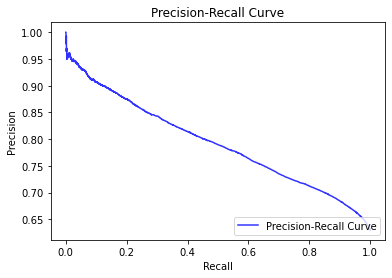

In [213]:
plt.plot(recall, precision, color='b', alpha=0.8, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [214]:
prec_thresholds = [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.63,0.6,0.55,0.5]  # Specify the precision thresholds of interest
for prec_threshold in prec_thresholds:
    idx = np.where(precision >= prec_threshold)[0][0]
    recall_at_prec_threshold = recall[idx]
    print("Recall at Precision Threshold {}: {:.3f}".format(prec_threshold, recall_at_prec_threshold))

Recall at Precision Threshold 0.95: 0.018
Recall at Precision Threshold 0.9: 0.123
Recall at Precision Threshold 0.85: 0.267
Recall at Precision Threshold 0.8: 0.456
Recall at Precision Threshold 0.75: 0.649
Recall at Precision Threshold 0.7: 0.849
Recall at Precision Threshold 0.65: 0.979
Recall at Precision Threshold 0.63: 1.000
Recall at Precision Threshold 0.6: 1.000
Recall at Precision Threshold 0.55: 1.000
Recall at Precision Threshold 0.5: 1.000


precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')## 4.Mtrics eval of 3 models: 

In [215]:
precision_score(y_true=test['label_trx_size'].astype(str).tolist(), y_pred=test['xgb_pred'].astype(str).tolist()\
                , average='micro').round(4)

0.6302

In [216]:
precision_score(y_true=test['label_trx_size'].astype(str).tolist(), y_pred=test['xgb_pred'].astype(str).tolist()\
                , average='micro').round(5)

0.63016

## Prev

In [ ]:
# Convert true labels and predicted labels to appropriate format
y_true = test['label_trx_size'].tolist()
y_pred = test['xgb_pred'].tolist()

# Calculate the total number of true positives, false negatives, and false positives
TP = 0
FN = 0
FP = 0

for true_label, pred_label in zip(y_true, y_pred):
    if true_label == pred_label:
        TP += 1
    else:
        FN += 1
        FP += 1

# Calculate micro-averaged recall
micro_recall = TP / (TP + FN)
# Calculate micro-averaged precision
micro_precision = TP / (TP + FP)
micro_recall,micro_precision

(0.6301577934076991, 0.6301577934076991)

In [ ]:
y_true_bin = [1 if true_label == pred_label else 0 for true_label, pred_label in zip(y_true, y_pred)]

TP = sum(y_true_bin)  # Count the number of true positives
FN = len(y_true_bin) - TP  # Count the number of false negatives
FP = sum([1 for label in y_true_bin if label == 0])  # Count the number of false positives

# Calculate recall and precision
recall = TP / (TP + FN)
precision = TP / (TP + FP)

In [ ]:
recall,precision

(0.6301577934076991, 0.6301577934076991)

In [217]:
precision_score(y_true=test['label_trx_size'].astype(str).tolist(), y_pred=test['pred_rf'].astype(str).tolist(), average='micro').round(4)

0.6216

In [218]:
precision_score(y_true=test['label_trx_size'].astype(str).tolist(), y_pred=test['merged_mode'].astype(str).tolist(), average='micro').round(3)

0.617

In [133]:
recall_score(y_true=test['label_trx_size'].astype(str).tolist(), y_pred=test['xgb_pred'].astype(str).tolist()\
                , average='micro').round(4)

NameError: name 'recall_score' is not defined

In [219]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mae_xgb = mean_absolute_error(test['label_trx_size'].astype(float).tolist(), test['xgb_pred'].astype(float).tolist()).round(4)
mae_rf = mean_absolute_error(test['label_trx_size'].astype(float).tolist(), test['pred_rf'].astype(float).tolist()).round(4)
mae_mode = mean_absolute_error(test['label_trx_size'].astype(float).tolist(), test['merged_mode'].astype(float).tolist()).round(4)

print("MaE:", mae_xgb)
print("MAE:", mae_rf)
print("MAE:", mae_mode)

MaE: 0.494
MAE: 0.4918
MAE: 0.5167


In [157]:
test.columns

Index(['user_id', 'leaf_id', 'merged_std', 'merged_mean', 'merged_median',
       'merged_mode', 'merged_maxMinDiff', 'merged_countOfEvidence',
       'label_trx_size', 'pred_rf', 'y_pred_xgb_reg', 'xgb_class_int',
       'prob_correct'],
      dtype='object')

# Test examination:

In [136]:
cols=['user_id', 'leaf_id', 'merged_std', 'merged_mean', 'merged_median',
       'merged_mode', 'merged_maxMinDiff', 'merged_countOfEvidence',
       'label_trx_size' , 'pred_rf',  'xgb_pred','prob_predictedClass']

test.loc[(test['xgb_pred']==test['label_trx_size'])][cols].head(20)

KeyError: "['pred_rf', 'prob_correct'] not in index"

In [389]:
test.loc[((test['xgb_pred']==test['label_trx_size'] ) & (test.merged_countOfEvidence >100) & ((test.merged_std <0.250000)) )][cols].head(10)

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,pred_rf,xgb_pred,prob_correct
5480,1652118,15709,0.142368,10.986364,11.0,11.0,1.5,110,11.0,11.0,11.0,0.845867
15830,5252883,15709,0.154207,11.963470,12.0,12.0,1.5,219,12.0,12.0,12.0,0.844108
17184,5751984,15709,0.181230,12.946429,13.0,13.0,1.0,112,13.0,13.0,13.0,0.889259
25748,9307447,15709,0.000000,13.000000,13.0,13.0,0.0,273,13.0,13.0,13.0,0.918552
30464,11338607,15709,0.160806,11.982558,12.0,12.0,1.5,172,12.0,12.0,12.0,0.844108
39972,15415253,15709,0.116420,8.509091,8.5,8.5,1.0,110,8.5,8.5,8.5,0.803711
44449,18613280,15709,0.242182,10.187970,10.0,10.0,0.5,133,10.0,10.0,10.0,0.572868
47191,20134941,15709,0.237378,10.936782,11.0,11.0,1.0,174,11.0,11.0,11.0,0.654335
49317,21300628,15709,0.000000,14.000000,14.0,14.0,0.0,120,14.0,14.0,14.0,0.897386
55371,24656470,15709,0.249642,9.292432,9.5,9.5,1.5,925,9.5,9.5,9.5,0.577074


In [390]:
test.loc[((test['xgb_pred']==test['label_trx_size'] ) & (test.merged_countOfEvidence <10) & ((test.merged_std >0.250000)) )][cols].head(10)

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,pred_rf,xgb_pred,prob_correct
137,44657,15709,0.894427,8.500000,9.0,9.0,2.5,5,9.0,9.0,9.0,0.432903
219,70968,15709,0.314270,12.888889,13.0,13.0,1.0,9,13.0,13.0,13.0,0.844112
651,231060,95672,1.082532,6.875000,7.5,7.5,2.5,4,7.5,7.5,7.5,0.311867
659,233258,95672,0.408248,6.000000,6.0,5.5,1.0,3,6.0,6.0,6.0,0.222141
662,233533,15709,1.658312,8.750000,9.0,9.0,5.5,8,9.0,9.0,9.0,0.353951
663,233533,95672,0.774597,10.500000,11.0,11.0,2.0,5,11.0,11.0,11.0,0.581426
1307,422427,95672,0.400000,10.200000,10.0,10.0,1.0,5,10.0,10.0,10.0,0.526294
1314,425230,15709,1.299038,10.750000,11.5,11.5,3.0,4,11.5,11.5,11.5,0.502263
1341,433306,95672,0.433013,9.250000,9.5,9.5,1.0,4,9.5,9.5,9.5,0.514036
1402,450946,95672,0.316228,9.000000,9.0,9.0,1.0,5,9.0,9.0,9.0,0.589685


In [393]:
test.loc[((test['xgb_pred']==test['label_trx_size'] ) & (test.merged_countOfEvidence <10) & ((test.merged_std >0.250000)) )].shape

(5980, 14)

In [394]:
test.loc[((test['xgb_pred']!=test['label_trx_size'] ) & (test.merged_countOfEvidence <10) & ((test.merged_std >0.250000)) )].shape

(8063, 14)

In [407]:
test.loc[(test.merged_std <0.25)].prob_predictedClass.describe()

count    75067.000000
mean         0.647227
std          0.121764
min          0.208227
25%          0.560894
50%          0.598851
75%          0.765113
max          0.918552
Name: prob_correct, dtype: float64

In [409]:
test.columns

Index(['user_id', 'leaf_id', 'merged_std', 'merged_mean', 'merged_median',
       'merged_mode', 'merged_maxMinDiff', 'merged_countOfEvidence',
       'label_trx_size', 'pred_rf', 'y_pred_xgb_reg', 'xgb_class_int',
       'prob_correct', 'xgb_pred'],
      dtype='object')

In [411]:
test.loc[(test.merged_median != test.merged_mean)].prob_predictedClass.describe()

count    28461.000000
mean         0.535635
std          0.167275
min          0.071446
25%          0.462212
50%          0.548288
75%          0.637689
max          0.915978
Name: prob_correct, dtype: float64

In [412]:
test.loc[(test.merged_median== test.merged_mean) & (test.merged_median== test.merged_mode)].prob_predictedClass.describe()

count    66868.000000
mean         0.646456
std          0.121033
min          0.208227
25%          0.560894
50%          0.598851
75%          0.765113
max          0.918552
Name: prob_correct, dtype: float64

In [410]:
test.loc[(test.merged_median== test.merged_mean)].prob_predictedClass.describe()

count    75076.000000
mean         0.609045
std          0.158203
min          0.086277
25%          0.547326
50%          0.591873
75%          0.751883
max          0.918552
Name: prob_correct, dtype: float64

In [408]:
test.loc[(test.merged_std >0.25)].prob_predictedClass.describe()

count    24616.000000
mean         0.446202
std          0.170554
min          0.071446
25%          0.279387
50%          0.486464
75%          0.577074
max          0.894965
Name: prob_correct, dtype: float64

In [401]:
test.loc[(test.merged_countOfEvidence >10) & ((test.merged_std <0.250000))].prob_predictedClass.describe()

count    4870.000000
mean        0.774849
std         0.106922
min         0.350926
25%         0.725750
50%         0.812927
75%         0.845501
max         0.918552
Name: prob_correct, dtype: float64

In [399]:
test.loc[(test.merged_countOfEvidence <10) & ((test.merged_std >0.250000))].prob_predictedClass.describe()

count    14043.000000
mean         0.381949
std          0.156885
min          0.071446
25%          0.247445
50%          0.376144
75%          0.522043
max          0.859169
Name: prob_correct, dtype: float64

In [392]:
test.loc[((test['xgb_pred']!=test['label_trx_size'] ) & (test.merged_countOfEvidence <10) & ((test.merged_std >0.250000)) )][cols].head(10)

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,pred_rf,xgb_pred,prob_correct
31,10681,95672,0.408248,7.000000,7.00,6.5,1.0,3,8.0,7.0,7.0,0.353640
411,150444,15709,1.414214,8.000000,7.00,7.0,3.0,3,10.5,7.0,7.0,0.286621
808,283752,15709,1.000000,11.000000,11.00,10.0,2.0,2,10.0,12.0,12.0,0.248470
980,333330,15709,0.500000,9.500000,9.50,9.0,1.0,2,9.0,10.0,10.0,0.261194
1276,412459,15709,0.500000,8.500000,8.50,8.0,1.0,2,8.0,9.0,9.0,0.251652
1521,487861,15709,2.524103,10.812500,10.75,9.5,9.5,8,6.0,11.0,9.5,0.135565
2030,648891,95672,0.559017,9.750000,10.00,10.0,1.5,6,13.0,10.0,10.0,0.519171
2062,657666,95672,0.489898,7.900000,7.50,7.5,1.0,5,8.5,7.5,7.5,0.469989
2271,718368,15709,0.748331,8.200000,8.00,7.5,2.0,5,8.5,8.0,7.5,0.218444
2426,761063,95672,0.606676,9.583333,9.50,9.0,1.5,6,10.5,9.0,10.0,0.247765


In [139]:
cols=['user_id', 'leaf_id', 'merged_std', 'merged_mean', 'merged_median',
       'merged_mode', 'merged_maxMinDiff', 'merged_countOfEvidence',
       'label_trx_size' ,   'xgb_pred','prob_predictedClass']

In [140]:
test.loc[~(test['xgb_pred']==test['label_trx_size'])][cols].head(10)
#errors

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,xgb_pred,prob_predictedClass
30,10555,95672,0.000000,10.0000,10.00,10.0,0.0,1,9.5,10.0,0.659499
31,10681,95672,0.408248,7.0000,7.00,6.5,1.0,3,8.0,7.0,0.483086
79,24200,15709,0.242061,11.1875,11.00,11.0,0.5,16,11.5,11.0,0.572588
82,25134,15709,0.250000,10.2500,10.25,10.0,0.5,4,10.5,10.0,0.541061
88,26812,95672,0.000000,9.5000,9.50,9.5,0.0,2,9.0,9.5,0.659848
149,47703,15709,0.000000,8.0000,8.00,8.0,0.0,7,12.0,8.0,0.799496
171,55036,15709,0.000000,11.0000,11.00,11.0,0.0,1,10.0,11.0,0.584948
208,66938,95672,0.000000,7.5000,7.50,7.5,0.0,2,8.0,7.5,0.610434
239,78549,95672,0.250000,9.2500,9.25,9.0,0.5,4,9.5,9.0,0.495236
356,125483,15709,0.000000,11.0000,11.00,11.0,0.0,1,10.5,11.0,0.584948


In [141]:
test.loc[(test['xgb_pred']==test['label_trx_size'])][cols].head(10)
#correct:

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,xgb_pred,prob_predictedClass
49,14654,15709,0.000000,10.500000,10.5,10.5,0.0,1,10.5,10.5,0.563983
59,19942,15709,0.000000,11.500000,11.5,11.5,0.0,1,11.5,11.5,0.546292
117,37770,15709,0.000000,12.000000,12.0,12.0,0.0,5,12.0,12.0,0.781402
137,44657,15709,0.894427,8.500000,9.0,9.0,2.5,5,9.0,9.0,0.733534
153,48318,15709,0.000000,12.000000,12.0,12.0,0.0,1,12.0,12.0,0.655168
173,55491,15709,0.000000,8.500000,8.5,8.5,0.0,2,8.5,8.5,0.740435
177,56088,15709,0.000000,11.500000,11.5,11.5,0.0,1,11.5,11.5,0.546292
189,61868,15709,0.000000,7.000000,7.0,7.0,0.0,2,7.0,7.0,0.610004
202,65395,95672,0.364216,10.785714,11.0,11.0,1.0,14,11.0,11.0,0.421435
203,65504,95672,0.000000,8.500000,8.5,8.5,0.0,1,8.5,8.5,0.548024


In [395]:
test.loc[ (test['xgb_pred']!=test['label_trx_size'])][cols].head(10)

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,pred_rf,xgb_pred,prob_correct
30,10555,95672,0.000000,10.0000,10.0,10.0,0.0,1,9.5,10.0,10.0,0.591873
31,10681,95672,0.408248,7.0000,7.0,6.5,1.0,3,8.0,7.0,7.0,0.353640
79,24200,15709,0.242061,11.1875,11.0,11.0,0.5,16,11.5,11.0,11.0,0.589694
88,26812,95672,0.000000,9.5000,9.5,9.5,0.0,2,9.0,9.5,9.5,0.701861
149,47703,15709,0.000000,8.0000,8.0,8.0,0.0,7,12.0,8.0,8.0,0.815293
171,55036,15709,0.000000,11.0000,11.0,11.0,0.0,1,10.0,11.0,11.0,0.598851
208,66938,95672,0.000000,7.5000,7.5,7.5,0.0,2,8.0,7.5,7.5,0.673938
356,125483,15709,0.000000,11.0000,11.0,11.0,0.0,1,10.5,11.0,11.0,0.598851
394,137405,15709,0.000000,12.5000,12.5,12.5,0.0,1,11.5,12.5,12.5,0.397960
411,150444,15709,1.414214,8.0000,7.0,7.0,3.0,3,10.5,7.0,7.0,0.286621


In [229]:
test.loc[(test['xgb_pred'].astype(float)!=test['pred_rf'].astype(float))& \
         (test['xgb_pred'].astype(float)!=test['label_trx_size'].astype(float))][cols].head(10)

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,pred_rf,xgb_pred,prob_correct
1521,487861,15709,2.524103,10.812500,10.75,9.5,9.5,8,6.0,11.0,9.5,0.135565
2271,718368,15709,0.748331,8.200000,8.00,7.5,2.0,5,8.5,8.0,7.5,0.218444
2340,739681,15709,3.294331,8.636364,6.50,12.0,7.5,33,12.0,12.0,13.0,0.145003
2426,761063,95672,0.606676,9.583333,9.50,9.0,1.5,6,10.5,9.0,10.0,0.247765
2597,803273,95672,3.250000,8.250000,8.25,5.0,6.5,2,10.0,11.5,11.0,0.170962
3725,1146720,15709,0.500000,11.000000,11.00,10.5,1.0,2,10.5,10.5,11.0,0.273905
4508,1373904,95672,2.132340,9.875000,9.75,7.0,6.0,4,9.0,12.0,7.0,0.124605
5428,1637809,15709,0.500000,11.000000,11.00,10.5,1.0,2,10.5,10.5,11.0,0.273905
8005,2444391,15709,0.500000,10.000000,10.00,9.5,1.0,2,9.5,10.5,10.0,0.222973
8941,2746449,15709,1.870829,9.500000,8.50,7.5,4.5,5,7.0,8.0,7.5,0.132060


In [474]:
test.loc[~(test['xgb_pred'].astype(float)==test['pred_rf'].astype(float))].shape

(2862, 14)

In [478]:
test.to_pickle("test_xgb_rf_multi.pkl")

In [484]:
test.head(15)

,user_id,leaf_id,merged_std,merged_mean,merged_median,merged_mode,merged_maxMinDiff,merged_countOfEvidence,label_trx_size,pred,pred_mode,pred_rf,y_pred_xgb_reg,xgb_class_int
8,2741,95672,0.000000,8.500000,8.5,8.5,0.0,2,8.5,9.0,9.0,8.5,8.559411,8.5
40,11010,15709,0.000000,14.000000,14.0,14.0,0.0,4,14.0,14.0,14.0,14.0,13.704306,14.0
55,14355,15709,0.000000,10.500000,10.5,10.5,0.0,3,10.5,11.0,11.0,10.5,10.414667,10.5
56,14468,95672,0.276385,7.583333,7.5,7.5,1.0,12,7.5,8.0,8.0,7.5,7.627636,7.5
65,19016,15709,0.000000,10.000000,10.0,10.0,0.0,16,10.0,10.0,10.0,10.0,9.953179,10.0
76,22439,15709,0.000000,10.000000,10.0,10.0,0.0,6,10.0,10.0,10.0,10.0,9.950782,10.0
84,23437,15709,0.000000,9.500000,9.5,9.5,0.0,2,9.5,10.0,10.0,9.5,9.489910,9.5
91,24595,95672,0.000000,10.000000,10.0,10.0,0.0,1,10.0,10.0,10.0,10.0,9.932903,10.0
109,29259,15709,0.000000,12.000000,12.0,12.0,0.0,1,12.0,12.0,12.0,12.0,11.685490,12.0
124,34305,15709,0.000000,10.000000,10.0,10.0,0.0,1,10.0,10.0,10.0,10.0,9.932903,10.0
